# Next 3 minutes (approx.) of your presentation -- Core Analysis
If you used ML (regression, classification, or something else); mention mainly WHICH one(s).
You may now briefly CLARIFY why and how the ML problem(s) aim(s) to solve your objective.
How did you apply ML technique(s) to SOLVE your problem? Which model(s), how and why?
Did you only use tools and techniques learned in this course? What ELSE did you learn / try?

#### Import libriaries and framework

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

#### Prepare the data

In [4]:
# Load the data from the CSV file into a DataFrame
data = pd.read_csv('datasets/listings_preprocessed.csv')

# Separate the input features (X) and target variable (y)
X = data.drop('price', axis=1)
y = data['price']

# Filter out non-numeric columns
numeric_columns = X.select_dtypes(include=['number']).columns
X_numeric = X[numeric_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# One-hot encode categorical features
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align the columns of the training and testing sets
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Fill missing values in the training set with the mean of each column
X_train.fillna(X_train.mean(), inplace=True)

# Fill missing values in the test set with the mean of the corresponding columns in the training set
X_test.fillna(X_train.mean(), inplace=True)

# Fill remaining NaN values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

#### Filter and extract only top 5 variables to be used to predict the price

In [30]:
def select_top_k_abs_correlated(X_train, y_train, X_test, k):
    # Calculate the correlation matrix between features and the target variable
    corr_matrix = X_train.corrwith(y_train)

    # Compute the absolute correlation values
    abs_corr_matrix = corr_matrix.abs()

    # Select the top k variables with the highest absolute correlation values
    top_k_abs_correlated = abs_corr_matrix.sort_values(ascending=False)[:k]

    # Print the top k variables
    print(f"Top {k} variables with the highest absolute correlation values:\n", top_k_abs_correlated)

    # Filter the original training and testing sets to include only the top k variables with the highest absolute correlation values
    X_train_selected = X_train[top_k_abs_correlated.index]
    X_test_selected = X_test[top_k_abs_correlated.index]

    return X_train_selected, X_test_selected, top_k_abs_correlated

X_train_selected, X_test_selected, top_k_abs_correlated = select_top_k_abs_correlated(X_train, y_train, X_test, k=5)

Top 5 variables with the highest absolute correlation values:
 room_type_Private room                         0.442091
bedrooms                                       0.425693
calculated_host_listings_count_entire_homes    0.410485
property_type_Private room in rental unit      0.400065
minimum_nights                                 0.389756
dtype: float64


#### Create the model and predict the data

#### Display the coefficients and performance metrics

In [37]:
def linear_regression_performance(X_train_selected, y_train, X_test_selected, y_test, top_k_abs_correlated):
    # Create a linear regression model
    model = LinearRegression()

    # Train the model using the training data with the selected features
    model.fit(X_train_selected, y_train)

    # Predict the prices for the test set
    y_pred = model.predict(X_test_selected)

    # Calculate the mean squared error and R^2 score for the predictions
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the coefficients of the linear regression model
    coefficients = model.coef_
    print("Linear regression model coefficients")
    for feature, coef in zip(top_k_abs_correlated.index, coefficients):
        print(f"{feature}: {coef}")

    # Print the results
    print("\nPerformance metrics")
    print("Mean squared error:", mse)
    print("R^2 score:", r2)

    return mse, r2, y_pred

mse, r2, y_pred = linear_regression_performance(X_train_selected, y_train, X_test_selected, y_test, top_k_abs_correlated)

Linear regression model coefficients
room_type_Private room: 11.130687059163224
bedrooms: 61.02163384412604
calculated_host_listings_count_entire_homes: 1.156179499690968
property_type_Private room in rental unit: -23.425640494241247
minimum_nights: -0.2820178159605271
maximum_minimum_nights: -0.7623950910827569
minimum_nights_avg_ntm: -0.823974863962165
minimum_minimum_nights: 1.1050942165164797
host_listings_count: 0.190781242405861
calculated_host_listings_count: -0.14501519169103624
host_total_listings_count: -0.24729803076932952
host_id: 9.609619908228001e-08
property_type_Entire rental unit: 42.30803129118394
accommodates: 4.868107918390126
property_type_Entire serviced apartment: 58.48361823639354

Performance metrics
Mean squared error: 7559.9836593279715
R^2 score: 0.541413544588087


#### Plot the regression model

#### Linear regression model for each variable predicting the price individually

#### loop through the top 5 positively correlated features

In [23]:
def individual_feature_performance(X_train_selected, y_train, X_test_selected, y_test, top_k_abs_correlated):
    # Initialize lists to store R^2 scores and coefficients
    r2_scores = []
    coefficients = []

    # Loop through the top k features with the highest absolute correlation values
    for feature in top_k_abs_correlated.index:
        # Create a linear regression model
        model = LinearRegression()

        # Train the model using the individual feature from the training data
        model.fit(X_train_selected[[feature]], y_train)

        # Predict the prices for the test set
        y_pred = model.predict(X_test_selected[[feature]])

        # Calculate the R^2 score for the predictions
        r2 = r2_score(y_test, y_pred)

        # Append the R^2 score and coefficient to the respective lists
        r2_scores.append(r2)
        coefficients.append(model.coef_[0])

    # Print the R^2 scores and coefficients for each feature
    for feature, r2, coef in zip(top_k_abs_correlated.index, r2_scores, coefficients):
        print(f"{feature}: R^2 = {r2:.4f}, Coefficient = {coef:.4f}")

    return r2_scores, coefficients

r2_scores, coefficients = individual_feature_performance(X_train_selected, y_train, X_test_selected, y_test, top_5_abs_correlated)

room_type_Private room: R^2 = 0.2129, Coefficient = -106.5430
bedrooms: R^2 = 0.2281, Coefficient = 90.1501
calculated_host_listings_count_entire_homes: R^2 = 0.1909, Coefficient = 0.7649
property_type_Private room in rental unit: R^2 = 0.1546, Coefficient = -118.4313
minimum_nights: R^2 = 0.1155, Coefficient = -1.0541


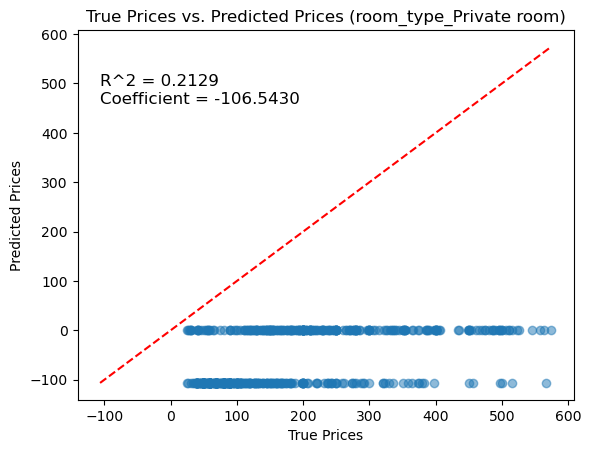

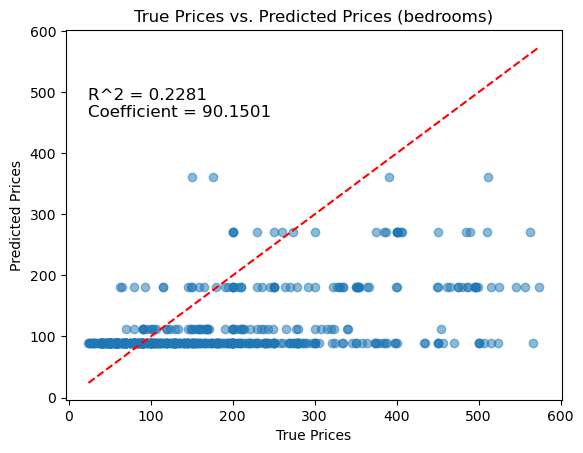

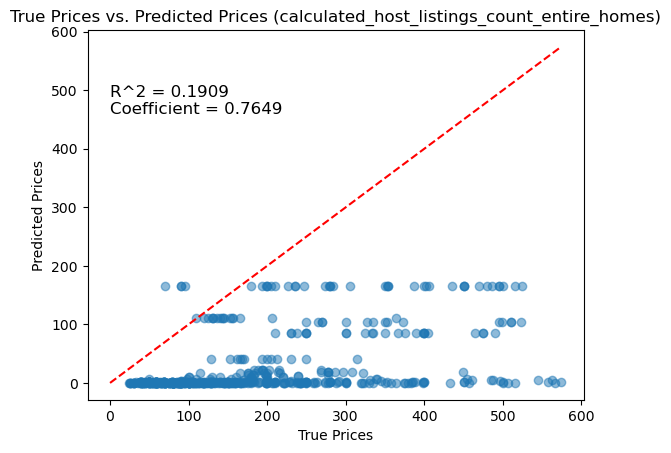

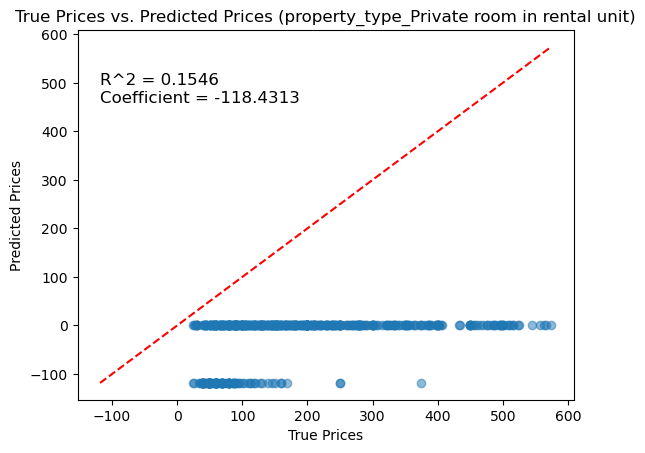

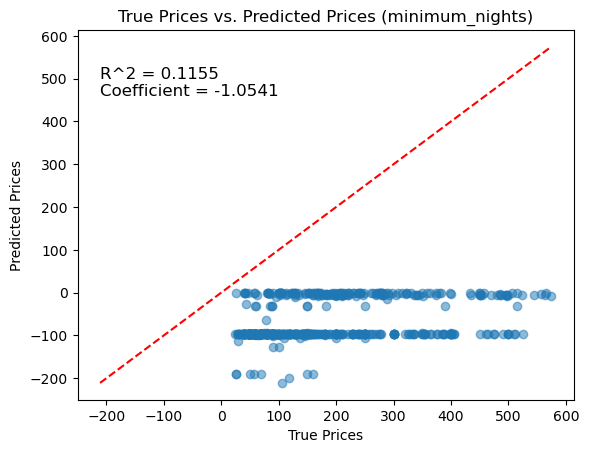

In [50]:
# Function to create a scatter plot for each feature
def plot_regression(feature, y_test, y_pred, r2, coef):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('True Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'True Prices vs. Predicted Prices ({feature})')

    min_val = min(y_test.min(), y_pred.min()[0])
    max_val = max(y_test.max(), y_pred.max()[0])
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    plt.text(min_val, max_val * 0.8, f'R^2 = {r2:.4f}\nCoefficient = {coef:.4f}', fontsize=12)
    plt.show()

# Loop through the top 5 positively correlated features and create a plot for each
for feature, r2, coef in zip(top_5_abs_correlated.index, r2_scores, coefficients):
    y_pred = X_test_selected[[feature]] * coef
    plot_regression(feature, y_test, y_pred, r2, coef)

#### Visualize the performance of the regression model

##### Create a scatter plot of the true prices (y_test) against the predicted prices (y_pred)

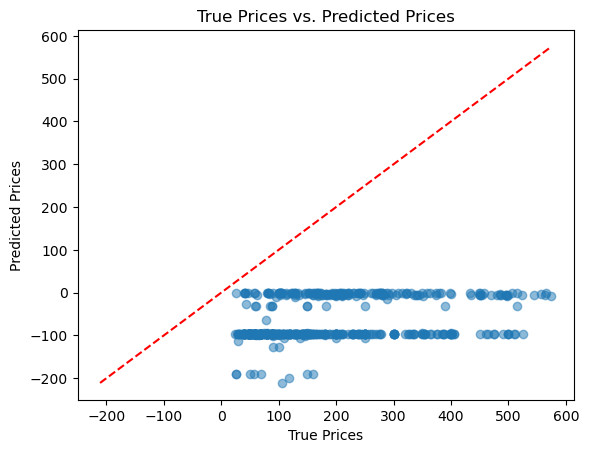

In [24]:
def plot_true_vs_predicted(y_test, y_pred):
    # Create a scatter plot of the true prices against the predicted prices
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('True Prices')
    plt.ylabel('Predicted Prices')
    plt.title('True Prices vs. Predicted Prices')

    # Convert y_test and y_pred to NumPy arrays
    y_test_np = np.array(y_test)
    y_pred_np = np.array(y_pred)

    # Add a diagonal line to represent perfect predictions
    min_val = min(y_test_np.min(), y_pred_np.min())
    max_val = max(y_test_np.max(), y_pred_np.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    # Show the plot
    plt.show()

plot_true_vs_predicted(y_test, y_pred)

##### Observation: using only top 5 variables does not seem it is viable for the prediction of prices

##### Solution: Include top 15 and 25 variables in the model

#### For top 15 variables based on absolute correlation values

##### Filter and extract data function

In [33]:
X_train_selected, X_test_selected, top_k_abs_correlated = select_top_k_abs_correlated(X_train, y_train, X_test, k=15)

Top 15 variables with the highest absolute correlation values:
 room_type_Private room                         0.442091
bedrooms                                       0.425693
calculated_host_listings_count_entire_homes    0.410485
property_type_Private room in rental unit      0.400065
minimum_nights                                 0.389756
maximum_minimum_nights                         0.389445
minimum_nights_avg_ntm                         0.386769
minimum_minimum_nights                         0.384322
host_listings_count                            0.347692
calculated_host_listings_count                 0.323658
host_total_listings_count                      0.316270
host_id                                        0.305003
property_type_Entire rental unit               0.288468
accommodates                                   0.284359
property_type_Entire serviced apartment        0.282429
dtype: float64


##### Create the model and predict the data and Display the coefficients and performance metrics

In [38]:
mse, r2, y_pred = linear_regression_performance(X_train_selected, y_train, X_test_selected, y_test, top_k_abs_correlated)

Linear regression model coefficients
room_type_Private room: 11.130687059163224
bedrooms: 61.02163384412604
calculated_host_listings_count_entire_homes: 1.156179499690968
property_type_Private room in rental unit: -23.425640494241247
minimum_nights: -0.2820178159605271
maximum_minimum_nights: -0.7623950910827569
minimum_nights_avg_ntm: -0.823974863962165
minimum_minimum_nights: 1.1050942165164797
host_listings_count: 0.190781242405861
calculated_host_listings_count: -0.14501519169103624
host_total_listings_count: -0.24729803076932952
host_id: 9.609619908228001e-08
property_type_Entire rental unit: 42.30803129118394
accommodates: 4.868107918390126
property_type_Entire serviced apartment: 58.48361823639354

Performance metrics
Mean squared error: 7559.9836593279715
R^2 score: 0.541413544588087


##### Linear regression model for each variable predicting the price individually

In [42]:
r2_scores, coefficients = individual_feature_performance(X_train_selected, y_train, X_test_selected, y_test, top_k_abs_correlated)

room_type_Private room: R^2 = 0.2129, Coefficient = -106.5430
bedrooms: R^2 = 0.2281, Coefficient = 90.1501
calculated_host_listings_count_entire_homes: R^2 = 0.1909, Coefficient = 0.7649
property_type_Private room in rental unit: R^2 = 0.1546, Coefficient = -118.4313
minimum_nights: R^2 = 0.1155, Coefficient = -1.0541
maximum_minimum_nights: R^2 = 0.1146, Coefficient = -1.0614
minimum_nights_avg_ntm: R^2 = 0.1143, Coefficient = -1.0524
minimum_minimum_nights: R^2 = 0.1141, Coefficient = -1.0414
host_listings_count: R^2 = 0.1260, Coefficient = 0.3034
calculated_host_listings_count: R^2 = 0.1144, Coefficient = 0.5965
host_total_listings_count: R^2 = 0.1106, Coefficient = 0.1629
host_id: R^2 = 0.0792, Coefficient = 0.0000
property_type_Entire rental unit: R^2 = 0.0829, Coefficient = 98.1885
accommodates: R^2 = 0.1139, Coefficient = 15.3518
property_type_Entire serviced apartment: R^2 = 0.0962, Coefficient = 112.1512


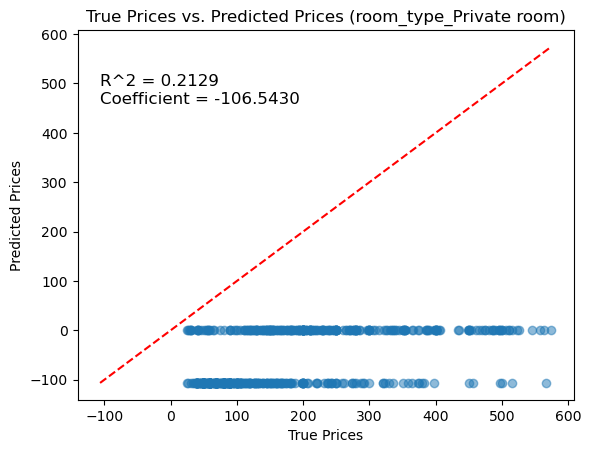

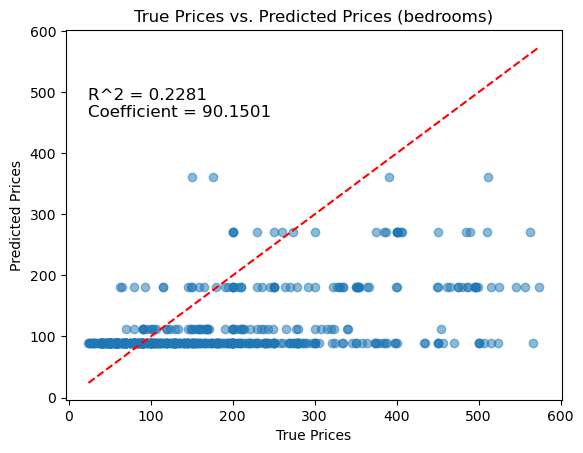

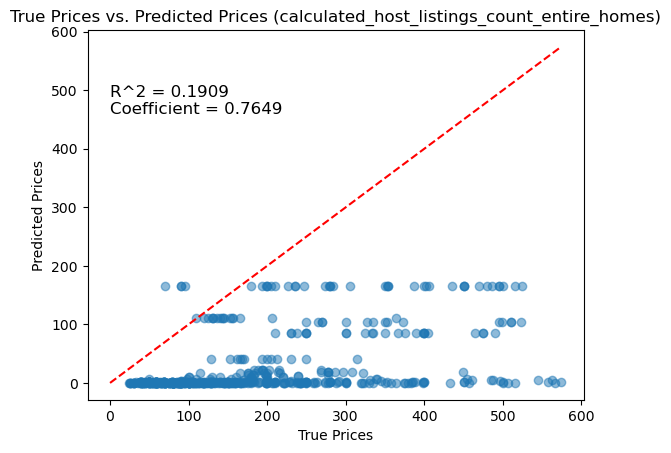

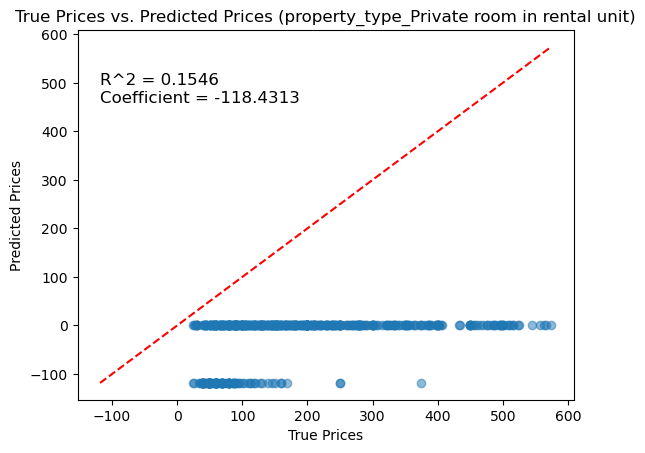

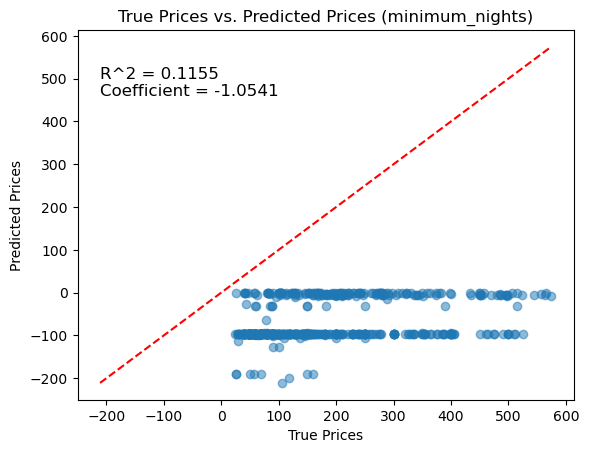

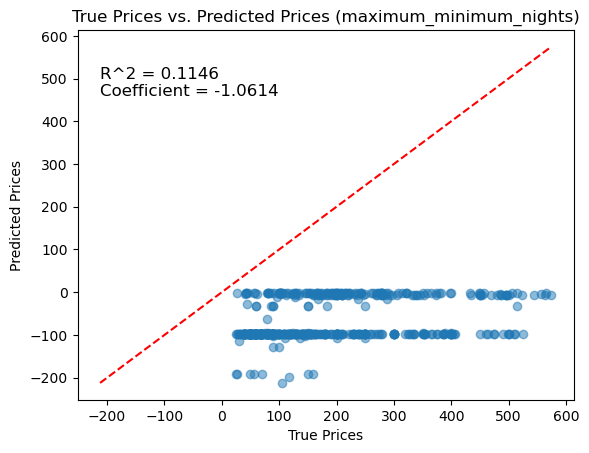

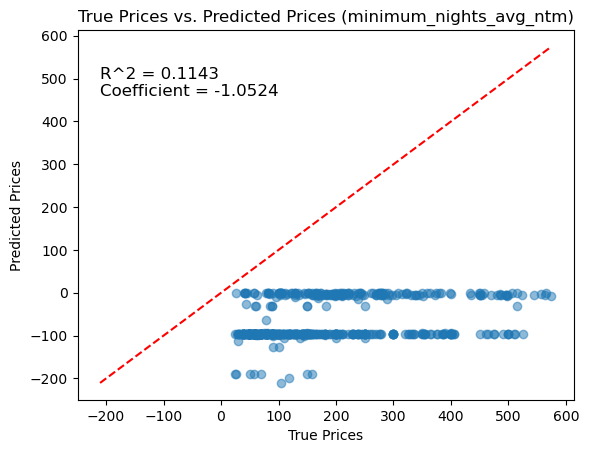

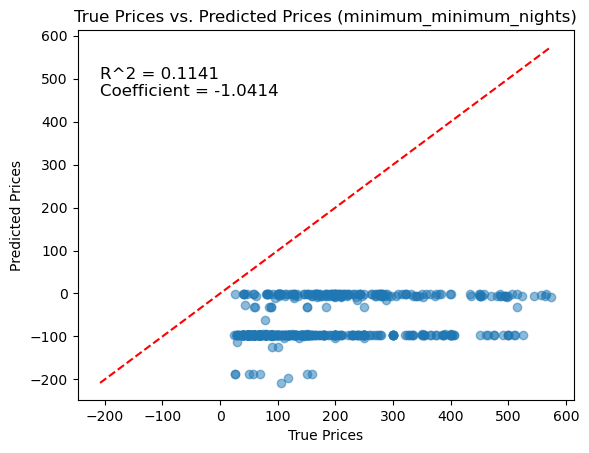

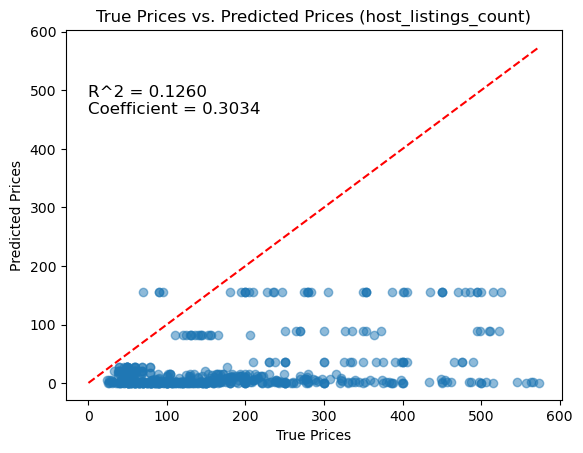

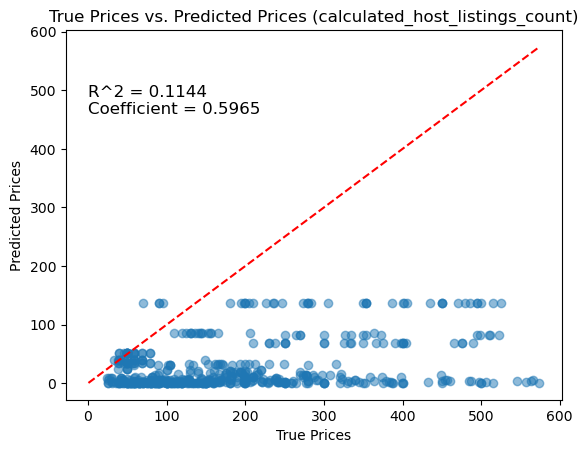

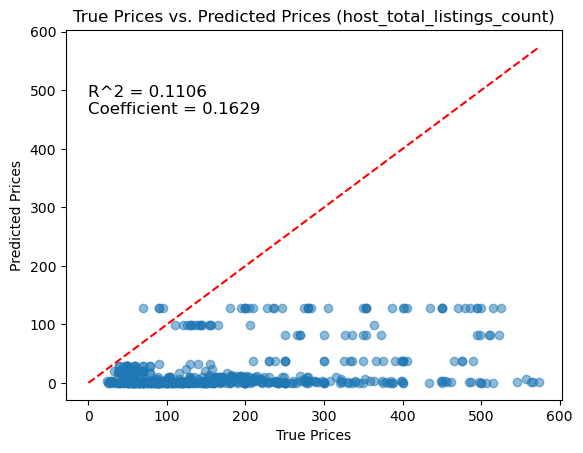

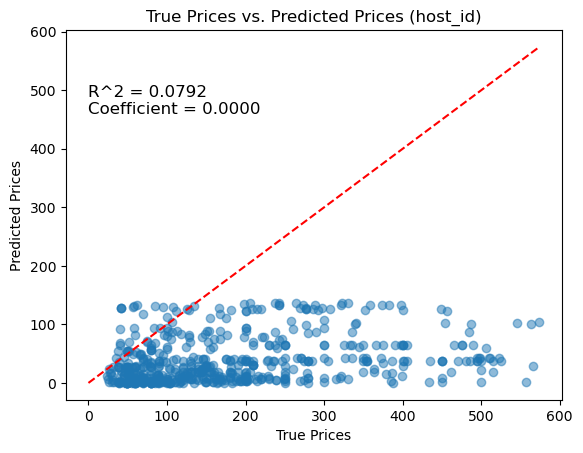

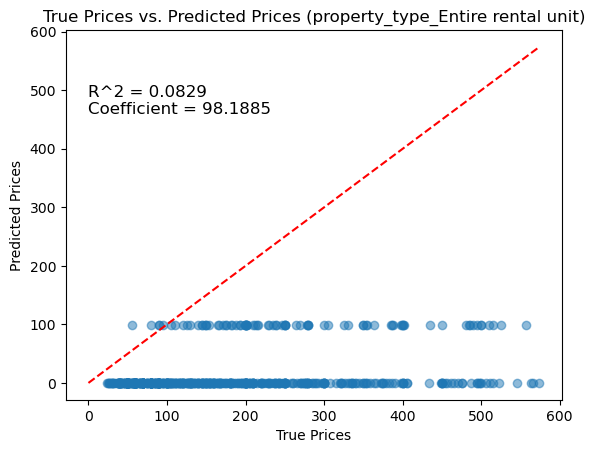

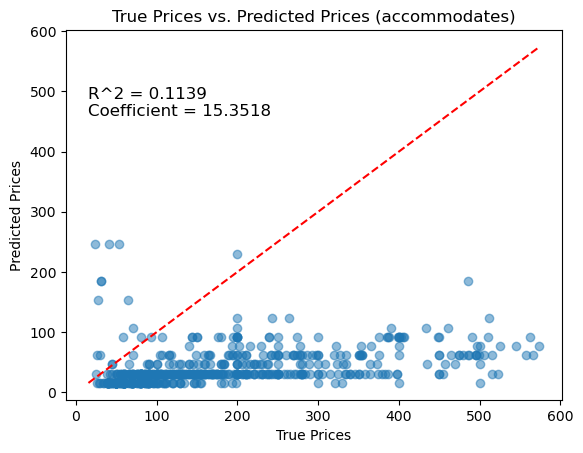

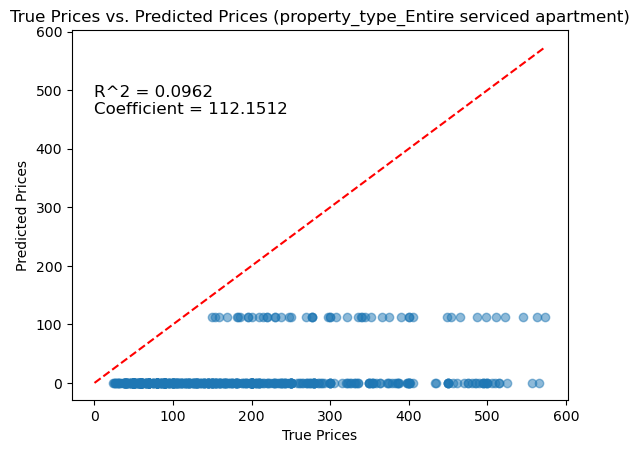

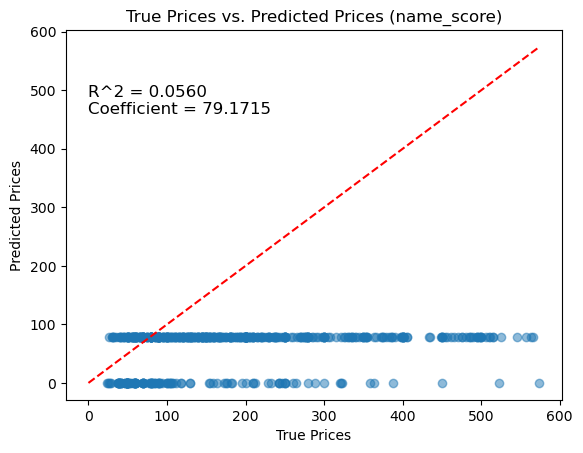

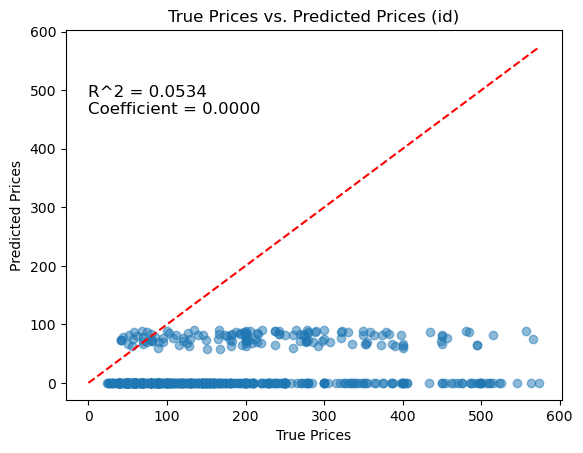

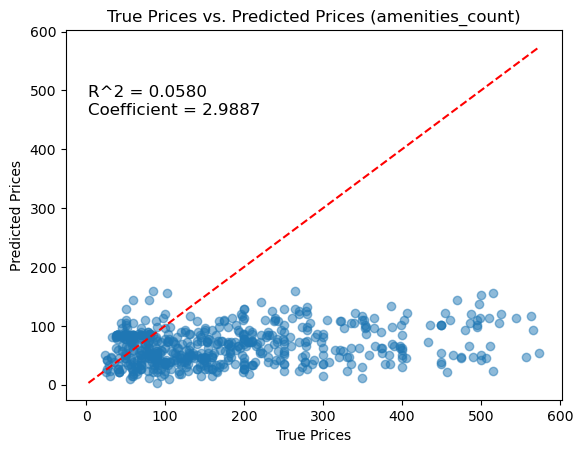

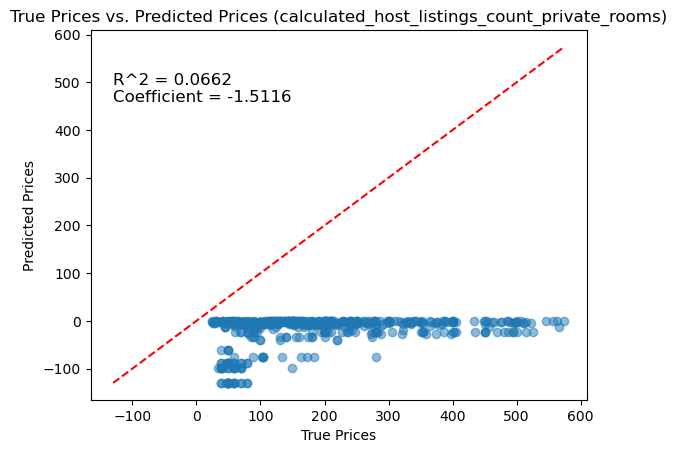

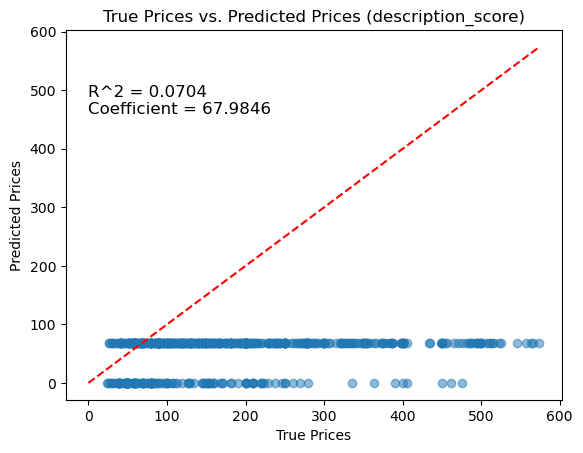

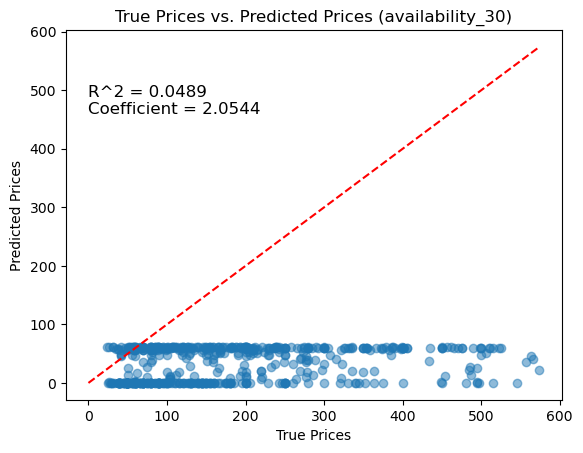

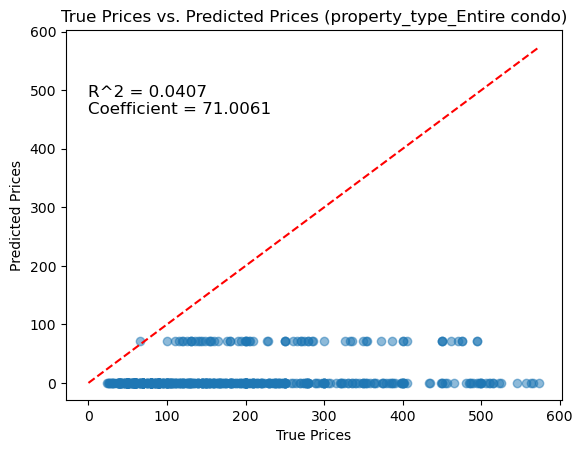

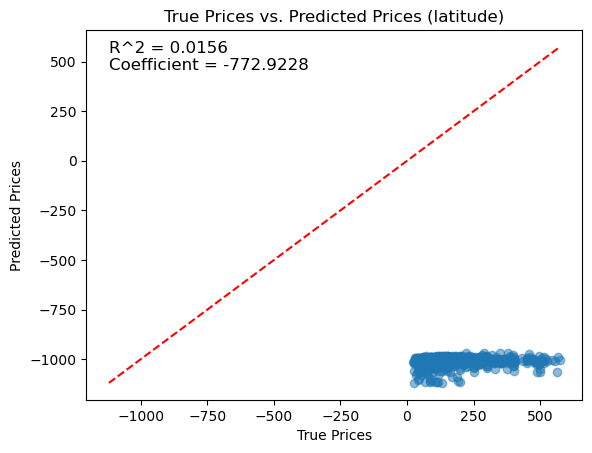

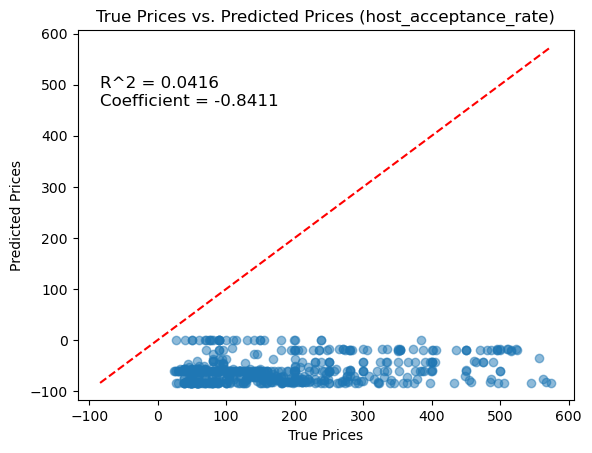

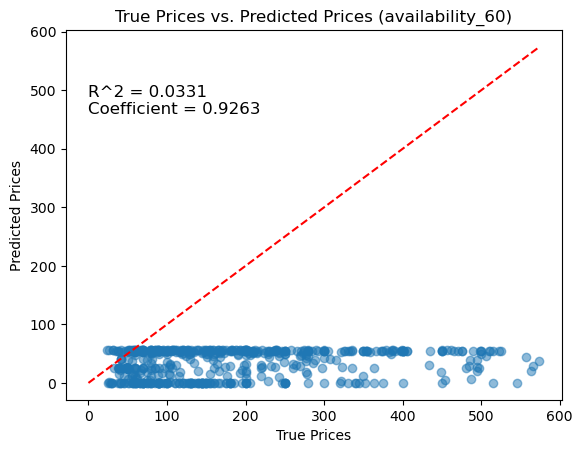

In [51]:
# Function to create a scatter plot for each feature
def plot_regression(feature, y_test, y_pred, r2_score, coefficients):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('True Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'True Prices vs. Predicted Prices ({feature})')

    min_val = min(y_test.min(), y_pred.min()[0])
    max_val = max(y_test.max(), y_pred.max()[0])
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    plt.text(min_val, max_val * 0.8, f'R^2 = {r2:.4f}\nCoefficient = {coef:.4f}', fontsize=12)
    plt.show()
    
# Loop through the top 15 positively correlated features and create a plot for each
for feature, r2, coef in zip(top_k_abs_correlated.index, r2_scores, coefficients):
    y_pred = X_test_selected[[feature]] * coef
    plot_regression(feature, y_test, y_pred, r2, coef)


##### Create a scatter plot of the true prices (y_test) against the predicted prices (y_pred)

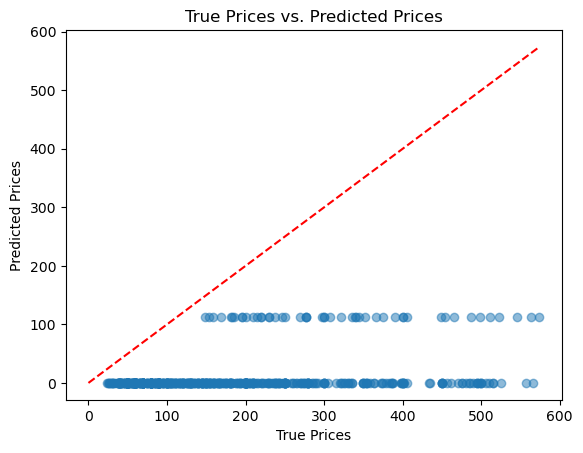

In [44]:
plot_true_vs_predicted(y_test, y_pred)

#### For top 25 variables based on absolute correlation values

##### Filter and extract data function

In [46]:
X_train_selected, X_test_selected, top_k_abs_correlated = select_top_k_abs_correlated(X_train, y_train, X_test, k=25)

Top 25 variables with the highest absolute correlation values:
 room_type_Private room                          0.442091
bedrooms                                        0.425693
calculated_host_listings_count_entire_homes     0.410485
property_type_Private room in rental unit       0.400065
minimum_nights                                  0.389756
maximum_minimum_nights                          0.389445
minimum_nights_avg_ntm                          0.386769
minimum_minimum_nights                          0.384322
host_listings_count                             0.347692
calculated_host_listings_count                  0.323658
host_total_listings_count                       0.316270
host_id                                         0.305003
property_type_Entire rental unit                0.288468
accommodates                                    0.284359
property_type_Entire serviced apartment         0.282429
name_score                                      0.280922
id                      

##### Create the model and predict the data and Display the coefficients and performance metrics

In [47]:
mse, r2, y_pred = linear_regression_performance(X_train_selected, y_train, X_test_selected, y_test, top_k_abs_correlated)

Linear regression model coefficients
room_type_Private room: -0.0005253032523833711
bedrooms: -6.328957138522323e-16
calculated_host_listings_count_entire_homes: 0.03728101014422276
property_type_Private room in rental unit: -0.000530219724547391
minimum_nights: -0.20393863377192886
maximum_minimum_nights: -0.20327689988250594
minimum_nights_avg_ntm: -0.20396303003761748
minimum_minimum_nights: -0.20457654089016347
host_listings_count: 0.08372834979598077
calculated_host_listings_count: 0.04315514237889276
host_total_listings_count: 0.11145066873371008
host_id: 1.7596335107001643e-07
property_type_Entire rental unit: -5.5964772151673216e-05
accommodates: 0.00017238444588231795
property_type_Entire serviced apartment: 0.0004595508084536267
name_score: -7.77077209550385e-06
id: 2.1804419982667623e-17
amenities_count: 0.015319189931098477
calculated_host_listings_count_private_rooms: 0.005006450664456311
description_score: 1.6295984081627424e-05
availability_30: -0.00020218872947792884
pr

##### Linear regression model for each variable predicting the price individually

In [48]:
r2_scores, coefficients = individual_feature_performance(X_train_selected, y_train, X_test_selected, y_test, top_k_abs_correlated)

room_type_Private room: R^2 = 0.2129, Coefficient = -106.5430
bedrooms: R^2 = 0.2281, Coefficient = 90.1501
calculated_host_listings_count_entire_homes: R^2 = 0.1909, Coefficient = 0.7649
property_type_Private room in rental unit: R^2 = 0.1546, Coefficient = -118.4313
minimum_nights: R^2 = 0.1155, Coefficient = -1.0541
maximum_minimum_nights: R^2 = 0.1146, Coefficient = -1.0614
minimum_nights_avg_ntm: R^2 = 0.1143, Coefficient = -1.0524
minimum_minimum_nights: R^2 = 0.1141, Coefficient = -1.0414
host_listings_count: R^2 = 0.1260, Coefficient = 0.3034
calculated_host_listings_count: R^2 = 0.1144, Coefficient = 0.5965
host_total_listings_count: R^2 = 0.1106, Coefficient = 0.1629
host_id: R^2 = 0.0792, Coefficient = 0.0000
property_type_Entire rental unit: R^2 = 0.0829, Coefficient = 98.1885
accommodates: R^2 = 0.1139, Coefficient = 15.3518
property_type_Entire serviced apartment: R^2 = 0.0962, Coefficient = 112.1512
name_score: R^2 = 0.0560, Coefficient = 79.1715
id: R^2 = 0.0534, Coeffi

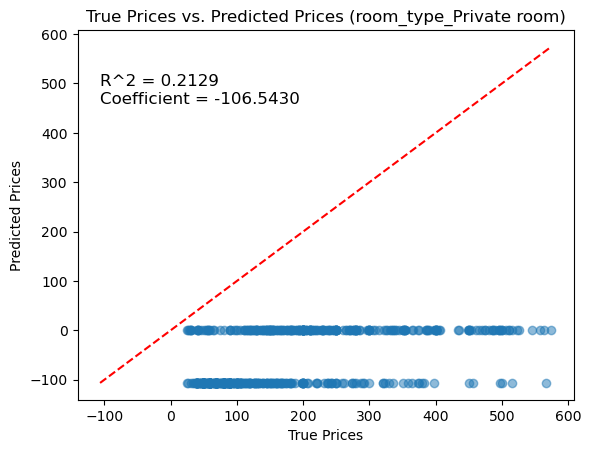

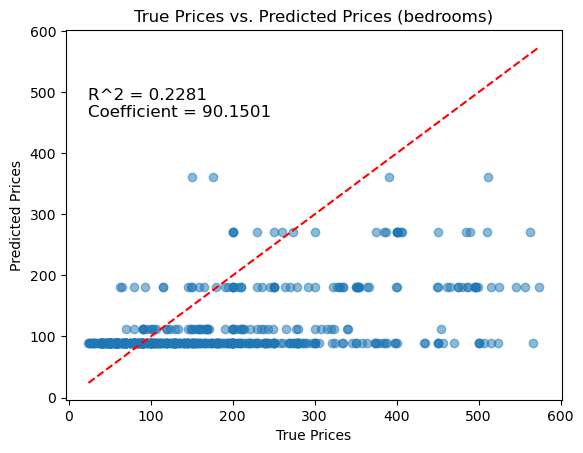

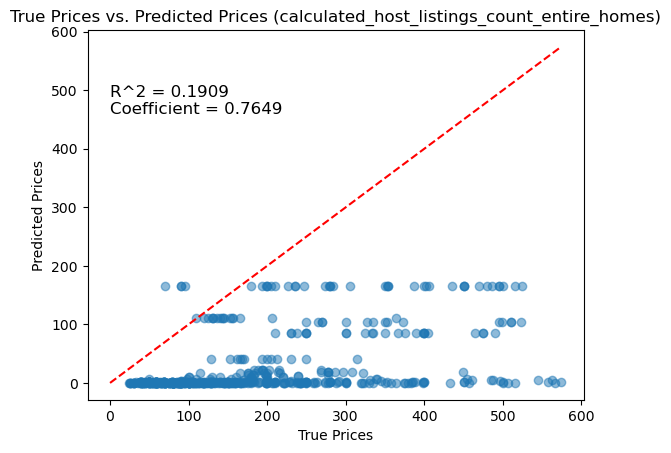

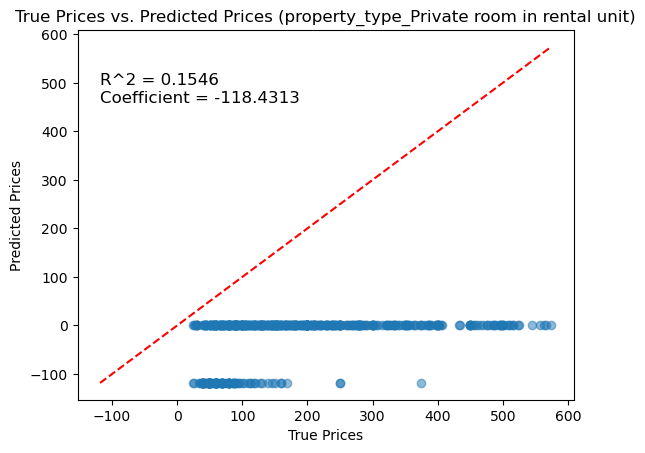

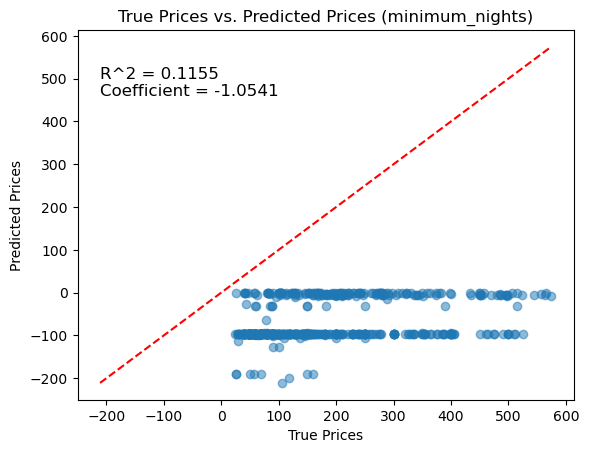

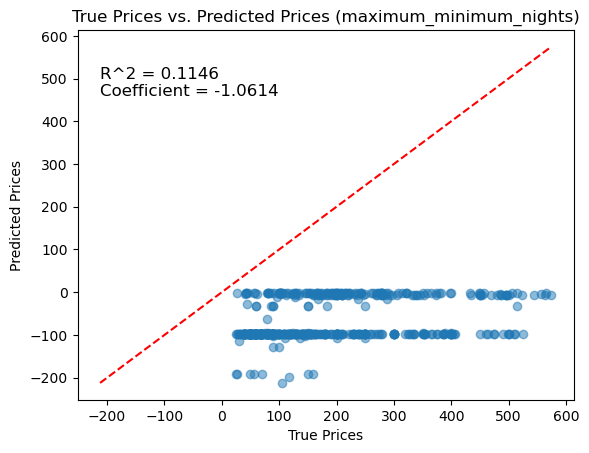

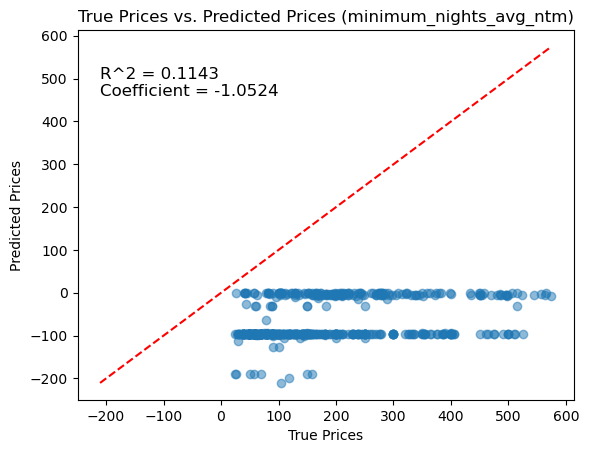

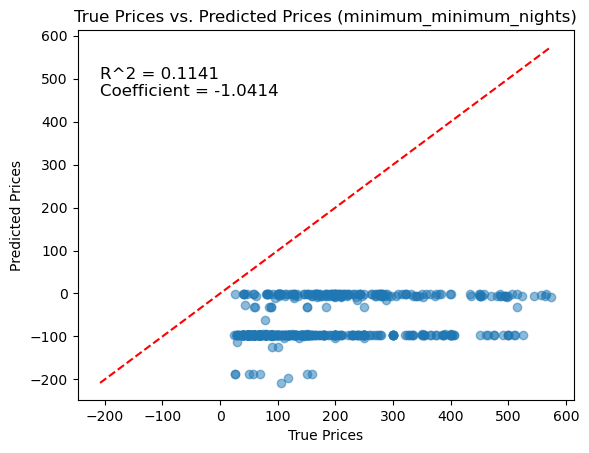

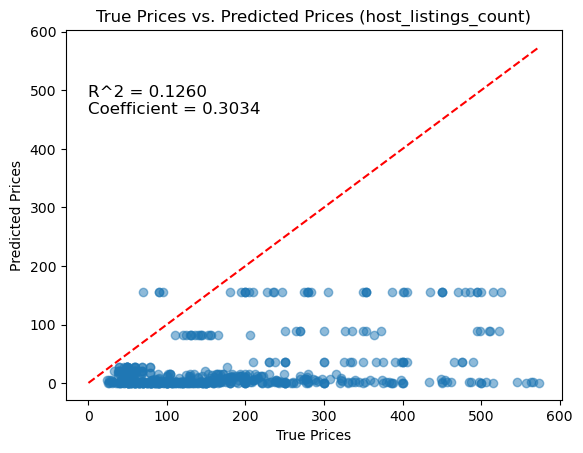

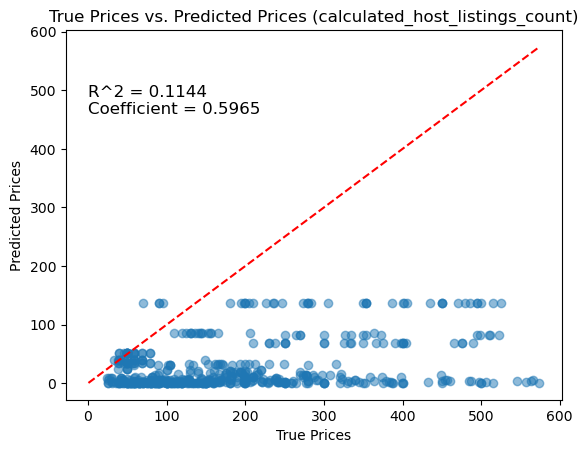

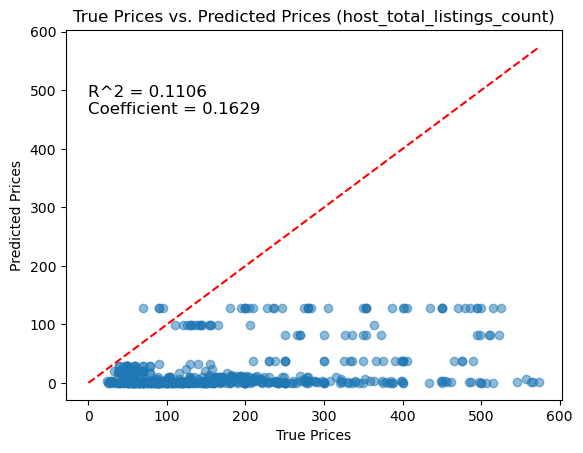

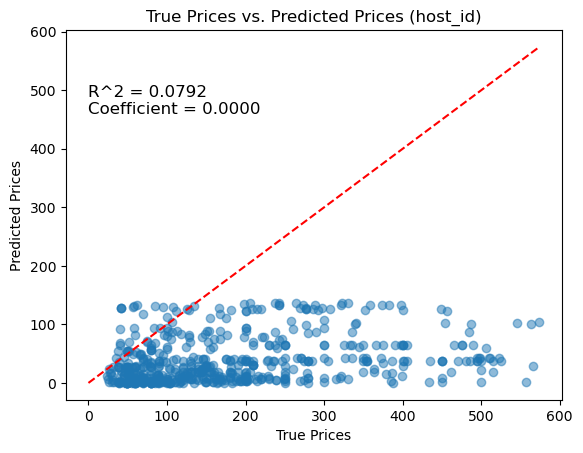

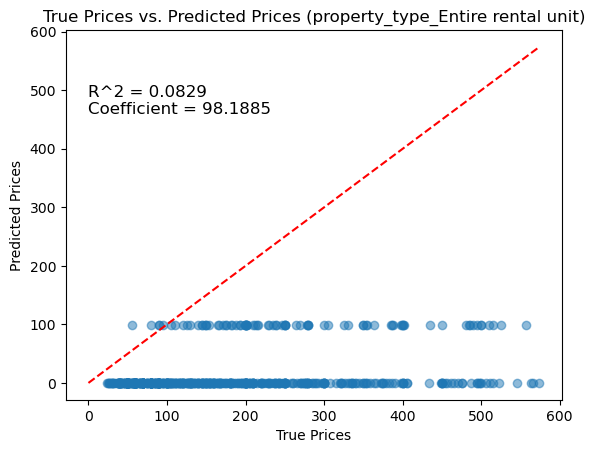

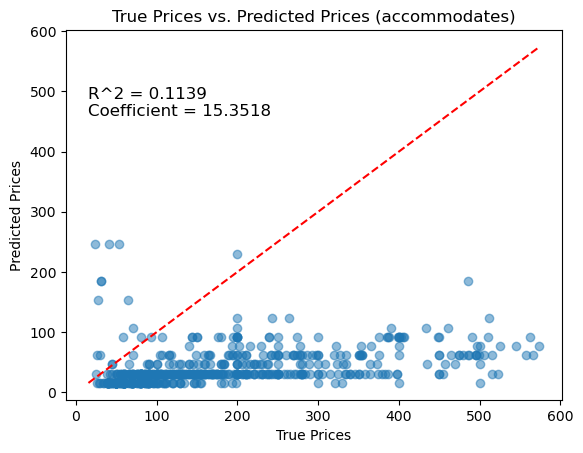

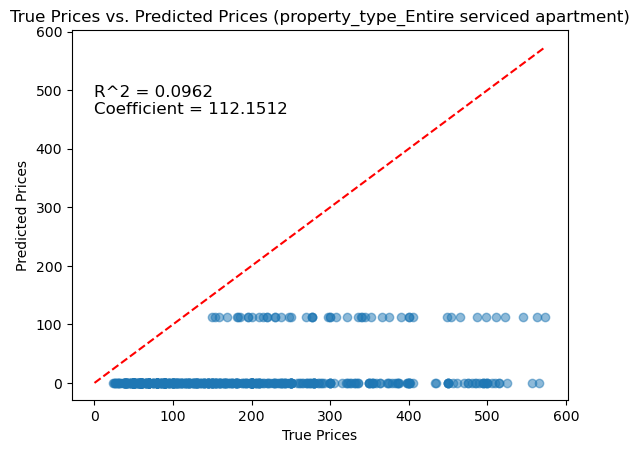

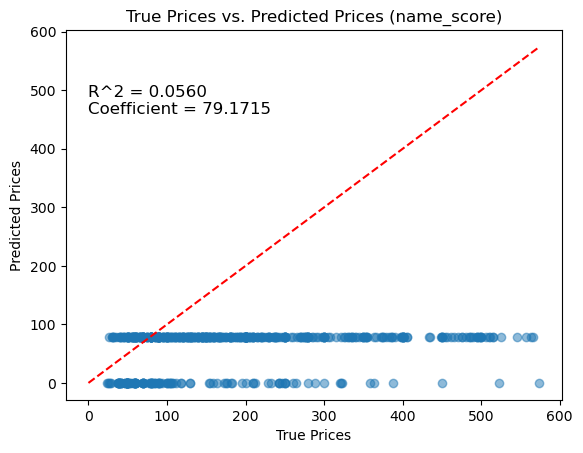

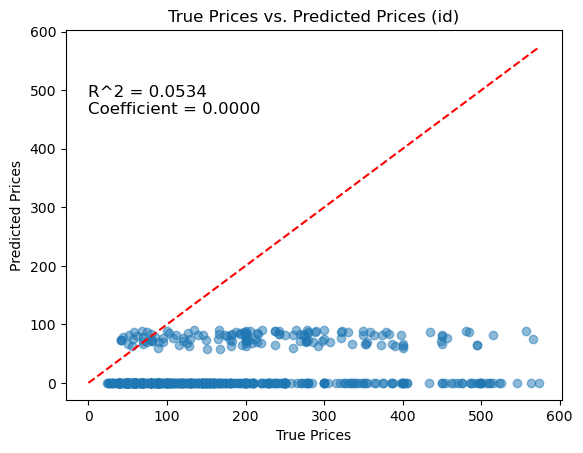

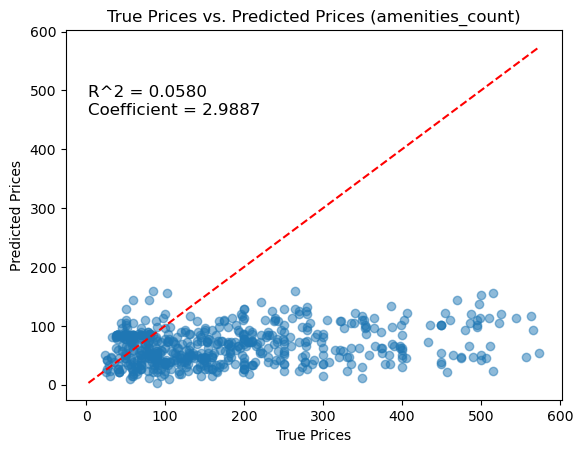

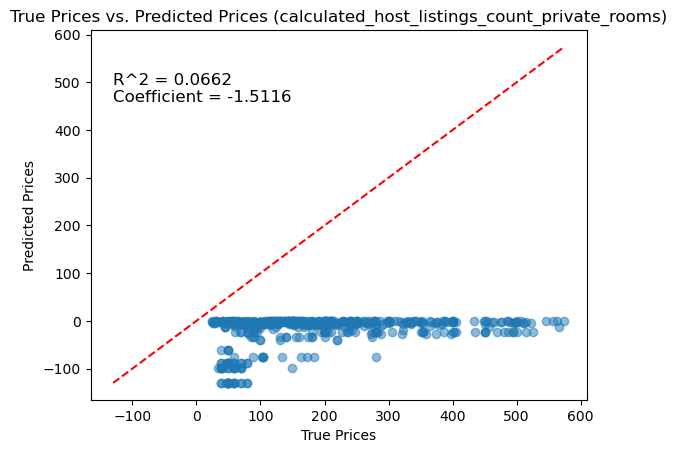

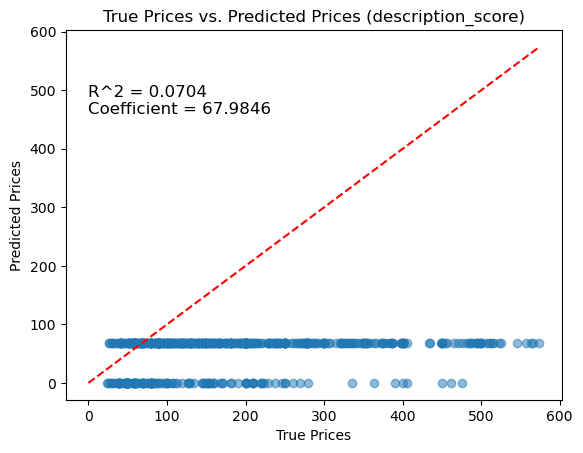

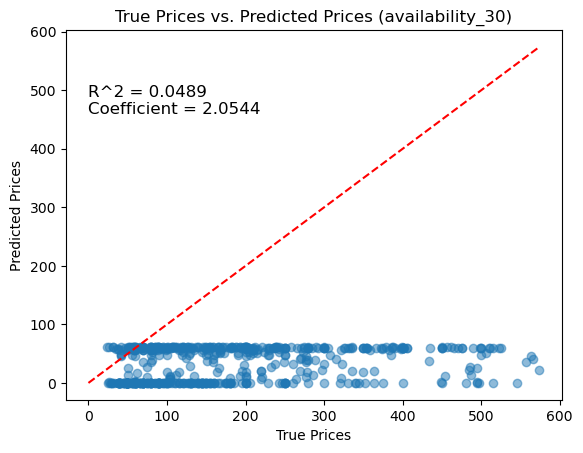

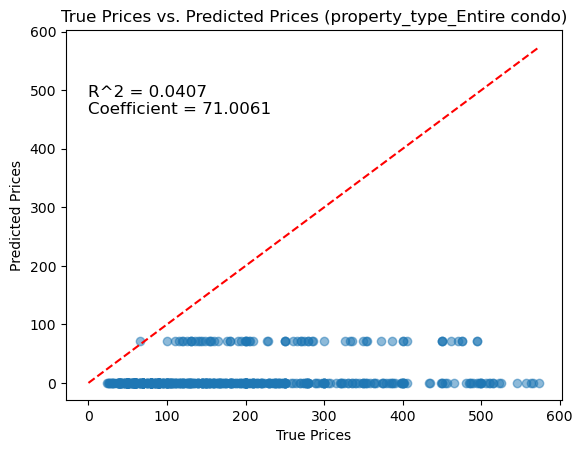

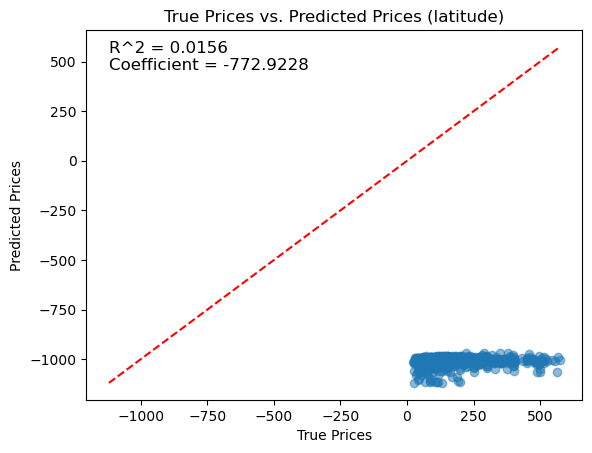

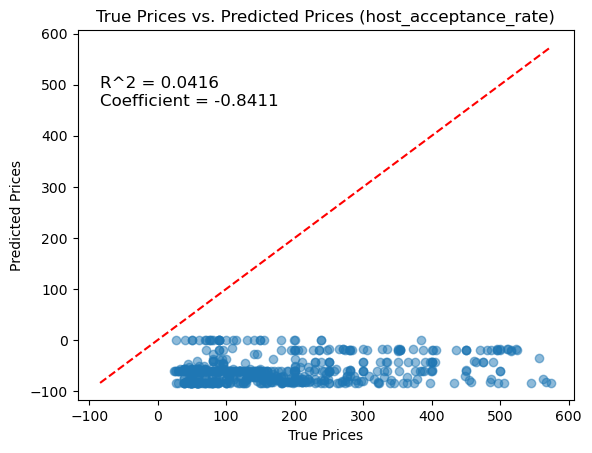

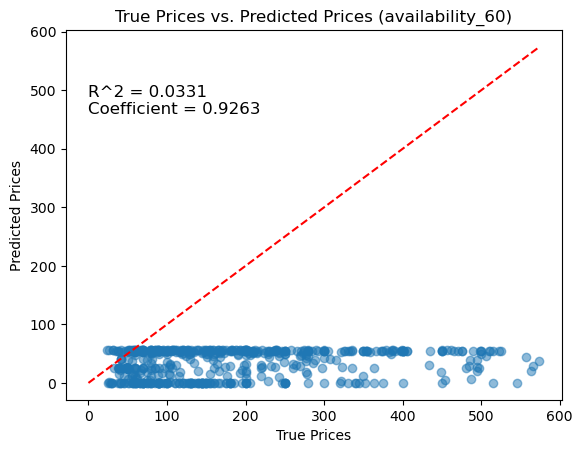

In [49]:
# Function to create a scatter plot for each feature
def plot_regression(feature, y_test, y_pred, r2_score, coefficients):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('True Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'True Prices vs. Predicted Prices ({feature})')

    min_val = min(y_test.min(), y_pred.min()[0])
    max_val = max(y_test.max(), y_pred.max()[0])
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    plt.text(min_val, max_val * 0.8, f'R^2 = {r2:.4f}\nCoefficient = {coef:.4f}', fontsize=12)
    plt.show()
    
# Loop through the top 25 positively correlated features and create a plot for each
for feature, r2, coef in zip(top_k_abs_correlated.index, r2_scores, coefficients):
    y_pred = X_test_selected[[feature]] * coef
    plot_regression(feature, y_test, y_pred, r2, coef)


##### Create a scatter plot of the true prices (y_test) against the predicted prices (y_pred)

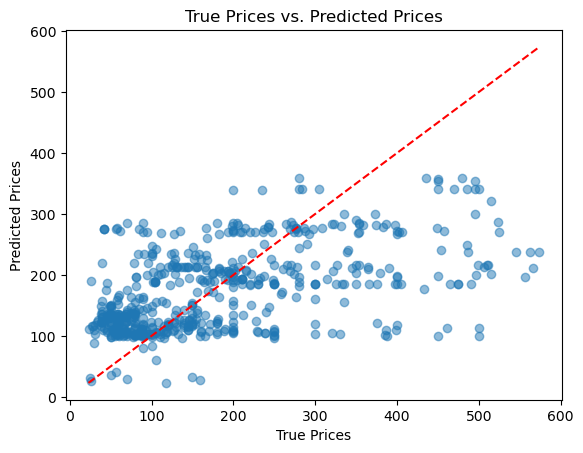

In [53]:
plot_true_vs_predicted(y_test, y_pred)